In [1]:
import torch
from functools import partial
from typing import List

import cutlass
import cutlass.cute as cute
from cutlass.cute.runtime import from_dlpack

# Kernel Tutorial: Building an Efficient Elementwise Add Kernel with CuTe DSL

This tutorial demonstrates how to implement and optimize a GPU elementwise addition kernel using the CuTe DSL. 

## Learning Objectives

In this tutorial, you will learn building an efficient elementwise kernel in CuTe DSL step by step:
- How to implement basic GPU kernels using CuTe DSL in basic CUDA techniques
- How to benchmark performance of the kernel
- How to tile and partition tensor and map to basic CuTe Layout
- What it Thread & Value Layout and mapping from thread & value index to logical coordinate
- How to implement advanced kernel with TV layout and tune performance to achieve peak performance

## Understanding Elementwise Addition

Elementwise addition is a fundamental operation in linear algebra and deep learning. Given two tensors of the same shape, the operation performs element-wise addition to produce a result tensor of the same shape.

For two 2D tensors $A$ and $B$ of shape $(M, N)$, the elementwise addition operation $C = A + B$ is defined as:

$
   C_{i,j} = A_{i,j} + B_{i,j}
$

where:
- $i \in [0, M-1]$ represents the row index
- $j \in [0, N-1]$ represents the column index
- $A_{i,j}$, $B_{i,j}$, and $C_{i,j}$ are the elements at position $(i,j)$ in tensors $A$, $B$, and $C$ respectively

This operation has several important characteristics:
1. **Parallelizable**: Each element can be computed independently
2. **Memory-bound**: Performance limited by memory bandwidth rather than compute
3. **Coalescing-sensitive**: Efficiency depends on memory access patterns
4. **Vectorization-friendly**: Multiple elements can be processed together

## Naive Elementwise Add Kernel

Let's start with a naive implementation to establish a baseline before exploring optimizations.

In [2]:
# Basic Kernel Implementation
# ---------------------
# This is our first implementation of the elementwise add kernel.
# It follows a simple 1:1 mapping between threads and tensor elements.


@cute.kernel
def naive_elementwise_add_kernel(
    gA: cute.Tensor,  # Input tensor A
    gB: cute.Tensor,  # Input tensor B
    gC: cute.Tensor,  # Output tensor C = A + B
):
    # Step 1: Get thread indices
    # ------------------------
    # CUDA threads are organized in a 3D grid of thread blocks
    # Here we only use the x-dimension for simplicity
    tidx, _, _ = cute.arch.thread_idx()  # Thread index within block (0 to bdim-1)
    bidx, _, _ = cute.arch.block_idx()  # Block index in grid (0 to grid_dim-1)
    bdim, _, _ = cute.arch.block_dim()  # Number of threads per block

    # Calculate global thread index
    # This gives each thread a unique ID across all blocks
    thread_idx = bidx * bdim + tidx  # Global thread ID

    # Step 2: Map thread index to tensor coordinates
    # -------------------------------------------
    # Each thread will process one element of the input tensors
    m, n = gA.shape  # Get tensor dimensions (M rows × N columns)

    # Convert linear thread index to 2D coordinates:
    # - ni: column index (0 to n-1)
    # - mi: row index (0 to m-1)
    ni = thread_idx % n  # Column index (faster varying dimension)
    mi = thread_idx // n  # Row index (slower varying dimension)

    # Step 3: Load and process data
    # ---------------------------
    # Load values from input tensors
    # The tensor layout automatically handles the conversion from
    # logical indices (mi, ni) to physical memory addresses
    a_val = gA[mi, ni]  # Load element from tensor A
    b_val = gB[mi, ni]  # Load element from tensor B

    # Step 4: Store result
    # ------------------
    # Write the sum back to the output tensor
    gC[mi, ni] = a_val + b_val

### Structure of the Kernel

The naive kernel implementation follows a straightforward but effective structure for parallel processing on the GPU. Here's a detailed breakdown of how it works:

1. **Thread Organization and Indexing**
   - Each CUDA thread is uniquely identified using a combination of:
     * `thread_idx` (tidx): Thread index within a block (0 to bdim-1)
     * `block_idx` (bidx): Block index in the grid
     * `block_dim` (bdim): Number of threads per block
   - Global thread ID is calculated as: `thread_idx = bidx * bdim + tidx`

2. **Coordinate Mapping**
   - The kernel maps each thread's global ID to 2D tensor coordinates:
     * `ni = thread_idx % n` (column index - faster varying)
     * `mi = thread_idx // n` (row index - slower varying)
   - This mapping ensures coalesced memory access by having adjacent threads access adjacent memory locations

3. **Memory Access Pattern**
   - Each thread:
     * Loads one element from tensor A: `a_val = gA[mi, ni]`
     * Loads one element from tensor B: `b_val = gB[mi, ni]`
     * Performs addition: `a_val + b_val`
     * Stores result to tensor C: `gC[mi, ni] = result`
   - Memory Considerations
     * Uses 1:1 thread-to-element mapping
     * Memory accesses are coalesced when threads in a warp access consecutive elements
     * No explicit use of shared memory or register blocking
     * Limited ability to hide memory latency due to single element processing

This naive implementation provides a baseline for understanding more optimized versions that follow, which introduce:
- Vectorized memory access
- Thread and value (TV) layouts
- Advanced tiling strategies
- Custom binary operations

For more details about coalesced memory access, please read: https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/#coalesced-access-to-global-memory


### Kernel Launch Configuration and Testing

This section demonstrates how to:
1. Configure and launch the kernel with `cute.jit` function
2. Set up test data with `torch`
3. Verify correctness

**Launch Configuration**
  - Uses 256 threads per block (common choice for good occupancy)
  - Grid size calculated based on total elements: `(m * n) // threads_per_block`
  - Single dimension block and grid configuration for simplicity

#### Host JIT function to launch kernel

In [3]:
@cute.jit  # Just-in-time compilation decorator
def naive_elementwise_add(
    mA: cute.Tensor,  # Input tensor A
    mB: cute.Tensor,  # Input tensor B
    mC: cute.Tensor,  # Output tensor C
):
    # Configure kernel launch parameters
    # --------------------------------
    # Choose number of threads per block
    # 256 is a common choice as it:
    # - Allows good occupancy on most GPUs
    # - Is a multiple of 32 (warp size)
    # - Provides enough threads for latency hiding
    num_threads_per_block = 256

    # Get input dimensions
    m, n = mA.shape  # Matrix dimensions (M rows × N columns)

    # Create kernel instance
    kernel = naive_elementwise_add_kernel(mA, mB, mC)

    # Launch kernel with calculated grid dimensions
    # -------------------------------------------
    # Grid size calculation:
    # - Total elements: m * n
    # - Blocks needed: ceil(total_elements / threads_per_block)
    # - Using integer division here assumes m * n is multiple of threads_per_block
    kernel.launch(
        grid=((m * n) // num_threads_per_block, 1, 1),  # Number of blocks in x,y,z
        block=(num_threads_per_block, 1, 1),  # Threads per block in x,y,z
    )

#### Setup test data with torch

In [4]:
# Test Setup
# ----------
# Define test dimensions
M, N = 16384, 8192  # Using large matrices to measure performance

# Create test data on GPU
# ----------------------
# Using float16 (half precision) for:
# - Reduced memory bandwidth requirements
# - Better performance on modern GPUs
a = torch.randn(M, N, device="cuda", dtype=torch.float16)  # Random input A
b = torch.randn(M, N, device="cuda", dtype=torch.float16)  # Random input B
c = torch.zeros(M, N, device="cuda", dtype=torch.float16)  # Output buffer

# Calculate total elements for bandwidth calculations
num_elements = sum([a.numel(), b.numel(), c.numel()])

# Convert PyTorch tensors to CuTe tensors
# -------------------------------------
# from_dlpack creates CuTe tensor views of PyTorch tensors
# assumed_align=16 ensures proper memory alignment for vectorized access
a_ = from_dlpack(a, assumed_align=16)  # CuTe tensor A
b_ = from_dlpack(b, assumed_align=16)  # CuTe tensor B
c_ = from_dlpack(c, assumed_align=16)  # CuTe tensor C

#### Compile and run

In [5]:
# Compile the kernel for the specific input types
naive_elementwise_add_ = cute.compile(naive_elementwise_add, a_, b_, c_)

# Run the kernel
naive_elementwise_add_(a_, b_, c_)

# Verify Results
# -------------
# Compare our kernel output with PyTorch's native implementation
torch.testing.assert_close(c, a + b)  # Raises error if results don't match

## Performance Analysis and Benchmarking

To understand and improve our kernel's performance, we need to measure its execution time and memory throughput. Let's analyze several key metrics:

* **Execution Time**
   - Measures raw kernel performance in microseconds
   - Lower is better
   - Affected by GPU clock speed, memory bandwidth, and kernel efficiency
* **Memory Throughput**
   - Measures how fast we can copy data (GB/s)
   - Higher is better
   - Theoretical peak varies by GPU model
   - For elementwise add:
     * Read: 2 elements (A and B)
     * Write: 1 element (C)
     * Total bytes = (2 reads + 1 write) × elements × sizeof(dtype)

Below is our benchmarking utility that measures these metrics:

In [6]:
def benchmark(callable, a_, b_, c_):
    avg_time_us = cute.testing.benchmark(
        callable,
        kernel_arguments=cute.testing.JitArguments(a_, b_, c_),
        warmup_iterations=5,
        iterations=100,
    )

    # Calculate metrics
    # ----------------
    dtype = a_.element_type

    # Calculate total bytes transferred:
    # - 2 reads (A and B) + 1 write (C)
    # - Each element is dtype.width bits
    bytes_per_element = dtype.width // 8
    total_bytes = num_elements * bytes_per_element

    # Calculate achieved bandwidth
    achieved_bandwidth = total_bytes / (avg_time_us * 1000)  # GB/s

    # Print results
    # ------------
    print(f"Performance Metrics:")
    print(f"-------------------")
    print(f"Kernel execution time: {avg_time_us:.4f} us")
    print(f"Memory throughput: {achieved_bandwidth:.2f} GB/s")

In [7]:
benchmark(naive_elementwise_add_, a_, b_, c_)

Performance Metrics:
-------------------
Kernel execution time: 415.2858 us
Memory throughput: 1939.16 GB/s


### Theoretical Analysis

This section analyze the performance characteristics and optimization opportunities of our elementwise addition kernel through several theoretical frameworks.

#### Little's Law

Little's Law provides crucial insights into relationship between latency, bandwidth and inflight operations:

$ L = \lambda \times W $

Where:
- $L$: Number of in-flight memory operations needed
- $\lambda$: Target memory bandwidth (bytes/cycle)
- $W$: Memory system latency (cycles)

According to *Little's Law*, naive implementation has
   - 1 element (4 bytes load + 2 bytes store) per thread
   - 256 threads/block × N blocks
   - Limited in-flight operations

In some GPUs, it's insufficient parallelism to saturate memory bandwidth.

#### Optimization Strategies

Based on this analysis, one commonly used technique is **Vectorization**. Instead of 1 element 
per load per thread, vectorization allows multiple element per load
   - Reduces instruction count
   - Improves memory coalescing
   - Increases operations in flight

## Vectorized Load and Store

To improve performance according to Little's Law, we need to increase the number
of in-flight requests. We can do this by increasing the number of bytes handled
in each load & store operation per thread through vectorized memory access.

Since Ampere GPUs support up to 128-bit per load/store and each element is 32-bit,
we can load 4 elements per vectorized operation on contiguous rows.
CuTe tiling operations make this vectorization straightforward.

Using ``tiled_tensor = cute.zipped_divide(tensor, tiler)``, we can partition the input
``tensor`` into groups of ``tiler`` blocks. For vectorization, we specify ``tiler``
as the block of data each thread accesses (4 contiguous elements in the same row, or ``(1,4)``).
Different threads can then access different blocks by indexing into the 2nd mode of ``tiled_tensor``.

```python
mA : cute.Tensor                           # (2048,2048):(2048,1)
gA = cute.zipped_divide(a, tiler=(1, 4))   # tiled/vectorized => ((1,4),(2048,512)):((0,1),(2048,4))
```

$
    \begin{array}{ccccc}
    & ((1,4) & , & (2048,512)) & : ((0,1),(2048,4)) \\
    & \underbrace{\phantom{(1,4)}}_{tiler} & & \underbrace{\phantom{(2048,512)}}_{threads} & \\
    & \text{\scriptsize per-thread} & & \text{\scriptsize num of tiles}
    \end{array}
$

In [8]:
@cute.kernel
def vectorized_elementwise_add_kernel(
    gA: cute.Tensor,
    gB: cute.Tensor,
    gC: cute.Tensor,
):
    tidx, _, _ = cute.arch.thread_idx()
    bidx, _, _ = cute.arch.block_idx()
    bdim, _, _ = cute.arch.block_dim()

    thread_idx = bidx * bdim + tidx

    # Map thread index to logical index of input tensor in unit of vector
    m, n = gA.shape[1]  # thread-domain
    ni = thread_idx % n
    mi = thread_idx // n

    # Map logical index to physical address via tensor layout
    a_val = gA[(None, (mi, ni))].load()
    b_val = gB[(None, (mi, ni))].load()
    print(f"[DSL INFO] sliced gA = {gA[(None, (mi, ni))]}")
    print(f"[DSL INFO] sliced gB = {gB[(None, (mi, ni))]}")

    # Perform element-wise addition
    gC[(None, (mi, ni))] = a_val + b_val

This vectorized kernel follows a similar structure to its naive non-vectorized counterpart,
with one key difference: the tensor slicing pattern. By using `(None, (mi, ni))` as the slice indices,
we can extract a `(1,4)` sub-tensor from `gA`, `gB` and `gC` like 

$ gA[(None, (mi, ni))]: $

$
  \begin{array}{ccccc}
    Layout: & ( & (1,4)                        & , & (2048,512) & )                    & : & ((0,1),(2048,4)) & \xrightarrow{\text{slice}} & ((1,4)):((0,1)) \\
            &   & \underbrace{\phantom{(1,4)}} &   & \underbrace{\phantom{(2048,512)}} &   & \\
    Coord:  & ( & None                         & , & (mi, ni)   & )                    &   &
  \end{array}
$

Then tensor data can be loaded into vector via the `gA[(None, (mi, ni))].load()` method. It is equivalent to

```python
v0 = gA[(0, (mi, ni))]   # => mA[(mi, ni * 4 + 0)]
v1 = gA[(1, (mi, ni))]   # => mA[(mi, ni * 4 + 1)]
v2 = gA[(2, (mi, ni))]   # => mA[(mi, ni * 4 + 2)]
v3 = gA[(3, (mi, ni))]   # => mA[(mi, ni * 4 + 3)]
```

### Assumed Alignment

In order to guide compile to use vectorized load/store, we must tell compiler to assume alignment of incoming pointer. 
It's on users side to guarantee actual pointer at runtime meet the alignment restriction.

```python
a_ = from_dlpack(a, assumed_align=16)
b_ = from_dlpack(b, assumed_align=16)
c_ = from_dlpack(c, assumed_align=16)

# Compile kernel with alignment assumption
compiled_func = cute.compile(vectorized_elementwise_add, a_, b_, c_)
```

It's worth to note that partitioned or tiled tensor could have different alignment of its base pointer because of offset
during sub-slice.

In [9]:
@cute.jit
def vectorized_elementwise_add(mA: cute.Tensor, mB: cute.Tensor, mC: cute.Tensor):
    threads_per_block = 256

    gA = cute.zipped_divide(mA, (1, 4))
    gB = cute.zipped_divide(mB, (1, 4))
    gC = cute.zipped_divide(mC, (1, 4))

    print("[DSL INFO] Tiled Tensors:")
    print(f"[DSL INFO]   gA = {gA}")
    print(f"[DSL INFO]   gB = {gB}")
    print(f"[DSL INFO]   gC = {gC}")

    vectorized_elementwise_add_kernel(gA, gB, gC).launch(
        grid=(cute.size(gC, mode=[1]) // threads_per_block, 1, 1),
        block=(threads_per_block, 1, 1),
    )


a = torch.randn(M, N, device="cuda", dtype=torch.float16)
b = torch.randn(M, N, device="cuda", dtype=torch.float16)
c = torch.zeros(M, N, device="cuda", dtype=torch.float16)

a_ = from_dlpack(a, assumed_align=16)
b_ = from_dlpack(b, assumed_align=16)
c_ = from_dlpack(c, assumed_align=16)

compiled_func = cute.compile(vectorized_elementwise_add, a_, b_, c_)
compiled_func(a_, b_, c_)

# verify correctness
torch.testing.assert_close(c, a + b)

[DSL INFO] Tiled Tensors:
[DSL INFO]   gA = tensor<ptr<f16, gmem, align<16>> o ((1,4),(16384,2048)):((0,1),(8192,4))>
[DSL INFO]   gB = tensor<ptr<f16, gmem, align<16>> o ((1,4),(16384,2048)):((0,1),(8192,4))>
[DSL INFO]   gC = tensor<ptr<f16, gmem, align<16>> o ((1,4),(16384,2048)):((0,1),(8192,4))>
[DSL INFO] sliced gA = tensor<ptr<f16, gmem, align<8>> o ((1,4)):((0,1))>
[DSL INFO] sliced gB = tensor<ptr<f16, gmem, align<8>> o ((1,4)):((0,1))>


In [10]:
benchmark(compiled_func, a_, b_, c_)

Performance Metrics:
-------------------
Kernel execution time: 260.4467 us
Memory throughput: 3092.02 GB/s


## TV Layout

Both the naive and vectorized kernels follow a common pattern to map thread indices
to physical addresses in two steps:

Step 1: Map thread index to logical coordinates in `(M, N)`

* `mi = thread_idx // n`
* `ni = thread_idx % n`

In native version, each thread process 1 element, in this case, `mi` and `ni` is logical
coordinate into data tensor `mA`, `mB` and `mC`.

Int vectorized version, each thread process multiple values of input and output tensor.
logical coordinate should be computed with both thread and value index.

* `thread_idx // n`
* `(thread_idx % n) * 4 + value_idx`


Step 2: Map logical coordinates in `(M, N)` to physical addresses using the tensor layout

* Vectorized Load

```python
    frgA = gA[(None, (mi, ni))].load()
```

* Elementwise Load (less efficient)

```python
    frgA0 = mA[(mi, ni * 4 + 0)]
    frgA1 = mA[(mi, ni * 4 + 1)]
    frgA2 = mA[(mi, ni * 4 + 2)]
    frgA3 = mA[(mi, ni * 4 + 3)]

    # Or use divided layout

    frgA0 = gA[(0, (mi, ni))]
    frgA1 = gA[(1, (mi, ni))]
    frgA2 = gA[(2, (mi, ni))]
    frgA3 = gA[(3, (mi, ni))]
```

CuTe introduces TV layout to represent this mapping from thread index and value index
(i.e., the 4 elements loaded per thread) to the logical coordinate space of a tensor.
By configuring different TV layouts, we can experiment with different memory access
patterns with minimal code changes.

**Definition:** *TV Layout* is rank-2 layout which maps `(thread_index, value_index)` 
to logical coordinate of tensor.  

We always have *TV Layout* with canonical form as `(thread_domain, value_domain):(..., ...)`.

With *TV Layout*, each thread can find logical coordinates or indices of data partitioned
to current thread.


## Elementwise with TV Layout

In this example, we rewrite elementwise kernel with two levels of tiling: 
* the thread-block level 
* the thread level with TV Layout and tiling

For thread-block level tiling, each input & output tensor is first divided
into a group of ``(TileM, TileN)`` sub-tensors at the host side. Please be noticed that
in this case, we still use `zipped_divide` but for tiling at thread-block level.

Inside the GPU kernel, we slice tiled tensor with the thread-block index at the 2nd mode 
as ``gA[((None, None), bidx)]``, which returns a thread-block local view of
a single ``(TileM, TileN)`` sub-tensor. This sub-tensor maps logical coordinates
inside ``(TileM, TileN)`` to physical address of elements.

At thread level tiling, we compose the above sub-tensor (logical coordinates to physical addresses) 
with the TV layout (thread & value indices to logical coordinates). This gives us a tiled sub-tensor 
that maps from thread & value indices directly to physical addresses.

We then slice it with the thread index as ``tidfrgA[(tidx, None)]`` to get 
a thread-local view of the data each thread accesses. Note that the thread index
is now in the 1st mode, as TV layout is normally have form ``(thread_domain, value_domain):(...)``.

### Kernel Code

In [11]:
@cute.kernel
def elementwise_add_kernel(
    gA: cute.Tensor, gB: cute.Tensor, gC: cute.Tensor, tv_layout: cute.Layout
):
    tidx, _, _ = cute.arch.thread_idx()
    bidx, _, _ = cute.arch.block_idx()

    # --------------------------------
    # slice for thread-block level view
    # --------------------------------
    blk_coord = ((None, None), bidx)

    # logical coord -> address
    blkA = gA[blk_coord]  # (TileM, TileN) -> physical address
    blkB = gB[blk_coord]  # (TileM, TileN) -> physical address
    blkC = gC[blk_coord]  # (TileM, TileN) -> physical address

    # --------------------------------
    # compose for thread-index & value-index to physical mapping
    # --------------------------------
    # blockA:    (TileM, TileN) -> physical address
    # tv_layout: (tid, vid)     -> (TileM, TileN)
    # tidfrgA = blkA o tv_layout
    # tidfrgA:   (tid, vid) -> physical address
    tidfrgA = cute.composition(blkA, tv_layout)
    tidfrgB = cute.composition(blkB, tv_layout)
    tidfrgC = cute.composition(blkC, tv_layout)

    print("Composed with TV layout:")
    print(f"  tidfrgA: {tidfrgA.type}")

    # --------------------------------
    # slice for thread-level view
    # --------------------------------
    # `None` represent slice of the entire per-thread data
    thr_coord = (tidx, None)
    # thr_coord = (tidx, cute.repeat_like(None, gA.shape[1]))

    # slice for threads: vid -> address
    thrA = tidfrgA[thr_coord]  # (V) -> physical address
    thrB = tidfrgB[thr_coord]  # (V) -> physical address
    thrC = tidfrgC[thr_coord]  # (V) -> physical address

    thrC[None] = thrA.load() + thrB.load()

### Host Code

The host code below shows the construction of the TV layout. By composing
a thread layout of ``(4,64):(64,1)`` (64 threads read contiguous elements on the row dimension,
then 64-thread-groups(2 warps) read different rows) with a value layout of ``(16,8):(8,1)`` (each thread reads
8 contiguous 16b elements on the row dimension across 4 contiguous rows).

In order to generalize, we started with byte-layout to describe layout for elements in bytes. This is
to ensure use of 128bit vectorized load store. Then we leverage ``recast_layout`` to convert into
element-layout.

```python
    # src type bits: 8
    # dst type bits: bits of element type
    val_layout = cute.recast_layout(dtype.width, 8, bit_val_layout)
```

In [12]:
@cute.jit
def elementwise_add(
    mA: cute.Tensor,
    mB: cute.Tensor,
    mC: cute.Tensor,
):
    # mA layout: (M, N):(N, 1)
    # TV layout map thread & value index to (64, 512) logical tile
    #  - contiguous thread index maps to mode-1 because input layout is contiguous on
    #     mode-1 for coalesced load-store
    #  - each thread load contiguous 16 bytes each row and load 16 rows
    coalesced_ldst_bytes = 16

    # Compile time validation: expect same element type for all input tensors
    assert all(t.element_type == mA.element_type for t in [mA, mB, mC])
    dtype = mA.element_type

    thr_layout = cute.make_ordered_layout((4, 64), order=(1, 0))
    val_layout = cute.make_ordered_layout((16, coalesced_ldst_bytes), order=(1, 0))
    val_layout = cute.recast_layout(dtype.width, 8, val_layout)
    tiler_mn, tv_layout = cute.make_layout_tv(thr_layout, val_layout)

    print(f"[DSL INFO] Tiler: {tiler_mn}")
    print(f"[DSL INFO] TV Layout: {tv_layout}")

    gA = cute.zipped_divide(mA, tiler_mn)  # ((TileM, TileN), (RestM, RestN))
    gB = cute.zipped_divide(mB, tiler_mn)  # ((TileM, TileN), (RestM, RestN))
    gC = cute.zipped_divide(mC, tiler_mn)  # ((TileM, TileN), (RestM, RestN))

    print("Tiled Input Tensors:")
    print("[DSL INFO] Tiled Tensors:")
    print(f"[DSL INFO]   gA = {gA.type}")
    print(f"[DSL INFO]   gB = {gB.type}")
    print(f"[DSL INFO]   gC = {gC.type}")

    # Launch the kernel asynchronously
    # Async token(s) can also be specified as dependencies
    elementwise_add_kernel(gA, gB, gC, tv_layout).launch(
        grid=[cute.size(gC, mode=[1]), 1, 1],
        block=[cute.size(tv_layout, mode=[0]), 1, 1],
    )


a = torch.randn(M, N, device="cuda", dtype=torch.float16)
b = torch.randn(M, N, device="cuda", dtype=torch.float16)
c = torch.zeros(M, N, device="cuda", dtype=torch.float16)

a_ = from_dlpack(a, assumed_align=16)
b_ = from_dlpack(b, assumed_align=16)
c_ = from_dlpack(c, assumed_align=16)

elementwise_add_ = cute.compile(elementwise_add, a_, b_, c_)
elementwise_add_(a_, b_, c_)

# verify correctness
torch.testing.assert_close(c, a + b)

[DSL INFO] Tiler: (64, 512)
[DSL INFO] TV Layout: ((64,4),(8,16)):((512,16),(64,1))
Tiled Input Tensors:
[DSL INFO] Tiled Tensors:
[DSL INFO]   gA = !cute.memref<f16, gmem, align<16>, "((64,512),(256,16)):((8192,1),(524288,512))">
[DSL INFO]   gB = !cute.memref<f16, gmem, align<16>, "((64,512),(256,16)):((8192,1),(524288,512))">
[DSL INFO]   gC = !cute.memref<f16, gmem, align<16>, "((64,512),(256,16)):((8192,1),(524288,512))">
Composed with TV layout:
  tidfrgA: !cute.memref<f16, gmem, align<16>, "((64,4),(8,16)):((8,131072),(1,8192))">


### Explanation of Layouts

Let's take a closer look using zipped divided input tensor `gA` as an example.
We also choose a smaller M/N, `(256,512)`, to make it easier to explain and visualize.

```
Tiled to Thread Block:

    ((16,256),(16,2))  : ((512,1),(8192,256))
     ~~~~~~~~  ~~~~~~      ~~~~~
        |        |           |
        |        |           |
        |        `-----------------------> Number of Thread Blocks
        |                    |
        |                    |
        `-------------------'
                  |
                  V
             Thread Block
                 Tile

Sliced to Thread-Block local sub-tensor (a (16, 256) tile):  gA[((None, None), bidx)]

    (16,256)   :  (512,1)
     ~~~~~~        ~~~~~~
        |             |        Tiled/Composed with TV Layout
        |             |
        |             |    o   ((32,4),(8,4)):((128,4),(16,1))
        V             V
~~~~~~~~~~~~~~~     ~~~~~~~~~~~~~~~~~~~
((32,4),(8,4))  :  ((8,2048),(1,512))
    |      |
    |      `--------> per thread fragment
    |
Thread Block
  Shape

Sliced to Thread local sub-tensor (a (4,8) tile):  tidfrgA[(tidx, None)]
```

### Visualization of TV Layout

To visualize TV Layout, we can first install *`cute-viz`*

```
pip install -U git+https://github.com/NTT123/cute-viz.git
```

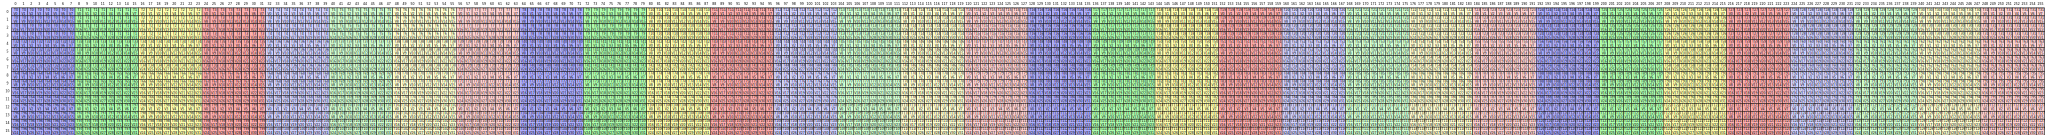

((32,4),(8,4)):((8,2048),(1,512))


: 

In [ ]:
try:
    from cute_viz import display_tv_layout

    @cute.jit
    def visualize():
        # Create and render a layout to file
        # layout = cute.make_layout( ((16,16),(256,2)), stride=((512,8192),(1,256)))
        # display_layout(layout)

        tv_layout = cute.make_layout(((32, 4), (8, 4)), stride=((128, 4), (16, 1)))
        display_tv_layout(tv_layout, (16, 256))

        thr_block_layout = cute.make_layout((16, 256), stride=(512, 1))
        print(cute.composition(thr_block_layout, tv_layout))

    visualize()
except ImportError:
    pass

***Why modes of thread domain of TV Layout looks swapped especially when tensor is row major?***

We may notice that *TV Layout* in above example is `((32,4),(8,4)):((128,4),(16,1))`. 
However, on visualization, thread indices are arrange as shape `(4,32)` rather than 
`(32,4)` of *TV Layout*.

This is a commonly asked question by developers from both internal teams and community.

It's important to keep in mind that *TV Layout* maps `(thread_index, value_index)` to 
`(row_index, column_index)` of logical domain `(TileM, TileN)`. However, visualization 
shows **inverse** mapping of logical domain `(TileM, TileN)` to `(thread_domain, value_domain)`,
because this is more intuitive for human developer.

That's why the shape of domain of *TV Layout* doesn't necessarily match logical view.

In [ ]:
benchmark(elementwise_add_, a_, b_, c_)

### Remap/Transpose thread block index

As tensors are row major in this example, we may want thread blocks to load contiguous memory as much as possible.

We can apply a simple thread-block remapping to transpose the mapping of thread block indices in row first order. 
`cute.composition(gA, (None, remap_block))` only apply transpose of 2nd mode of tiled layout but keep 
the 1st mode un-touched.

```python
    remap_block = cute.make_ordered_layout(
        cute.select(gA.shape[1], mode=[1, 0]), order=(1, 0)
    )
    gA = cute.composition(gA, (None, remap_block))
    gB = cute.composition(gB, (None, remap_block))
    gC = cute.composition(gC, (None, remap_block))
```

In [ ]:
@cute.jit
def elementwise_add(
    mA: cute.Tensor,
    mB: cute.Tensor,
    mC: cute.Tensor,
):
    # mA layout: (M, N):(N, 1)
    # TV layout map thread & value index to (64, 512) logical tile
    #  - contiguous thread index maps to mode-1 because input layout is contiguous on
    #     mode-1 for coalesced load-store
    #  - each thread load contiguous 16 bytes each row and load 16 rows
    coalesced_ldst_bytes = 16

    # Compile time validation: expect same element type for all input tensors
    assert all(t.element_type == mA.element_type for t in [mA, mB, mC])
    dtype = mA.element_type

    thr_layout = cute.make_ordered_layout((4, 64), order=(1, 0))
    val_layout = cute.make_ordered_layout((16, coalesced_ldst_bytes), order=(1, 0))
    val_layout = cute.recast_layout(dtype.width, 8, val_layout)
    tiler_mn, tv_layout = cute.make_layout_tv(thr_layout, val_layout)

    print(f"[DSL INFO] Tiler: {tiler_mn}")
    print(f"[DSL INFO] TV Layout: {tv_layout}")

    gA = cute.zipped_divide(mA, tiler_mn)  # ((TileM, TileN), (RestM, RestN))
    gB = cute.zipped_divide(mB, tiler_mn)  # ((TileM, TileN), (RestM, RestN))
    gC = cute.zipped_divide(mC, tiler_mn)  # ((TileM, TileN), (RestM, RestN))

    # (RestM, RestN) -> (RestN, RestM)
    remap_block = cute.make_ordered_layout(
        cute.select(gA.shape[1], mode=[1, 0]), order=(1, 0)
    )
    gA = cute.composition(gA, (None, remap_block))
    gB = cute.composition(gB, (None, remap_block))
    gC = cute.composition(gC, (None, remap_block))

    print("Tiled Input Tensors:")
    print("[DSL INFO] Tiled Tensors:")
    print(f"[DSL INFO]   gA = {gA.type}")
    print(f"[DSL INFO]   gB = {gB.type}")
    print(f"[DSL INFO]   gC = {gC.type}")

    # Launch the kernel asynchronously
    # Async token(s) can also be specified as dependencies
    elementwise_add_kernel(gA, gB, gC, tv_layout).launch(
        grid=[cute.size(gC, mode=[1]), 1, 1],
        block=[cute.size(tv_layout, mode=[0]), 1, 1],
    )


a = torch.randn(M, N, device="cuda", dtype=torch.float16)
b = torch.randn(M, N, device="cuda", dtype=torch.float16)
c = torch.zeros(M, N, device="cuda", dtype=torch.float16)

a_ = from_dlpack(a, assumed_align=16)
b_ = from_dlpack(b, assumed_align=16)
c_ = from_dlpack(c, assumed_align=16)

elementwise_add_ = cute.compile(elementwise_add, a_, b_, c_)
elementwise_add_(a_, b_, c_)

# verify correctness
torch.testing.assert_close(c, a + b)

In [ ]:
benchmark(compiled_func, a_, b_, c_)

## Using Lambda Function

CuTe DSL is built on top of Python. It can leverage Python to implement meta-programming to generate flexible kernels.
E.g. we can write kernel template that take custom binary operations to generate kernels for arbitrary binary operations.


```python
@cute.jit
def elementwise_apply(
    op: cutlass.Constexpr,
    inputs,
    result: cute.Tensor
):
    ...

```

In [ ]:
@cute.kernel
def elementwise_apply_kernel(
    op: cutlass.Constexpr,
    mInputs: List[cute.Tensor],
    mC: cute.Tensor,
    cC: cute.Tensor,  # coordinate tensor
    shape: cute.Shape,
    tv_layout: cute.Layout,  # (tid, vid) -> logic coord
):
    tidx, _, _ = cute.arch.thread_idx()
    bidx, _, _ = cute.arch.block_idx()

    ###############################################################################
    # Slice to local tile of thread block
    ###############################################################################
    blk_crd = ((None, None), bidx)

    # Leverage the meta-programming capability of the DSL to slice the tensors for each input
    # All for loops below on input tensors would be fully unrolled automatically at compile time
    # logical coord -> memory address
    gInputs = [t[blk_crd] for t in mInputs]  # (TileM, TileN)
    gC = mC[blk_crd]  # (TileM, TileN)
    gCrd = cC[blk_crd]  # (TileM, TileN)

    print("[DSL INFO] Sliced Tensors per thread block:")
    for i in cutlass.range_constexpr(len(gInputs)):
        print(f"[DSL INFO]   ctaInputs{i} = {gInputs[i].type}")
    print(f"[DSL INFO]   gC = {gC.type}")
    print(f"[DSL INFO]   gCrd = {gCrd.type}")

    ###############################################################################
    # Compose with thread block TV layout to map thread & value indices to memory address
    ###############################################################################
    # (tid, vid) -> memory address
    tidfrgInputs = [cute.composition(t, tv_layout) for t in gInputs]
    tidfrgC = cute.composition(gC, tv_layout)
    tidfrgCrd = cute.composition(gCrd, tv_layout)

    # repeat None like vid to remove hierarchy of layout
    thr_crd = (tidx, cute.repeat_like(None, tidfrgInputs[0][1]))

    ###############################################################################
    # Slice to local tile of thread
    ###############################################################################
    # vid -> address
    thrInputs = [t[thr_crd] for t in tidfrgInputs]  # (V)
    thrC = tidfrgC[thr_crd]  # (V)
    thrCrd = tidfrgCrd[thr_crd]

    print("[DSL INFO] Sliced Tensors per thread:")
    for i in cutlass.range_constexpr(len(thrInputs)):
        print(f"[DSL INFO]   thrInputs{i} = {thrInputs[i].type}")
    print(f"[DSL INFO]   thrC = {thrC.type}")
    print(f"[DSL INFO]   thrCrd = {thrCrd.type}")

    ###############################################################################
    # Compute predicate for out of boundary checks
    ###############################################################################
    frgPred = cute.make_fragment(thrCrd.shape, cutlass.Boolean)
    print(f"[DSL INFO]   frgPred = {frgPred.type}")

    for i in cutlass.range_constexpr(cute.size(frgPred)):
        frgPred[i] = cute.elem_less(thrCrd[i], shape)

    # if tidx == 0 and bidx == 0:
    #     cute.print_tensor(frgPred)

    ##########################################################
    # Load data and compute result
    ##########################################################

    # Load data before use. The compiler will optimize the copy and load
    # operations to convert some memory ld/st into register uses.
    result = op(*[thrInput.load() for thrInput in thrInputs])
    thrC.store(result)


@cute.jit
def elementwise_apply(op: cutlass.Constexpr, inputs, result: cute.Tensor):
    # Use 128bit(16B) load as canonicalized form of val_layout then recast to target element-type
    coalesced_ldst_bytes = 16

    # Compile time validation: expect same element type for all input tensors
    assert all(t.element_type == inputs[0].element_type for t in inputs)
    dtype = inputs[0].element_type

    thr_layout = cute.make_ordered_layout((4, 64), order=(1, 0))
    val_layout = cute.make_ordered_layout((16, coalesced_ldst_bytes), order=(1, 0))
    val_layout = cute.recast_layout(dtype.width, 8, val_layout)
    tiler_mn, tv_layout = cute.make_layout_tv(thr_layout, val_layout)

    mInputs = [cute.zipped_divide(input, tiler_mn) for input in inputs]
    mC = cute.zipped_divide(result, tiler_mn)  # ((TileM, TileN), (RestM, RestN))

    # (RestM, RestN) -> (RestN, RestM)
    remap_block = cute.make_ordered_layout(
        cute.select(mInputs[0].shape[1], mode=[1, 0]), order=(1, 0)
    )
    for i, t in enumerate(mInputs):
        mInputs[i] = cute.composition(t, (None, remap_block))

    mC = cute.composition(mC, (None, remap_block))

    idC = cute.make_identity_tensor(result.shape)
    cC = cute.zipped_divide(idC, tiler=tiler_mn)

    # Launch the kernel asynchronously
    # Group input tensors into a list as a single argument
    elementwise_apply_kernel(op, mInputs, mC, cC, result.shape, tv_layout).launch(
        grid=[cute.size(mC, mode=[1]), 1, 1],
        block=[cute.size(tv_layout, mode=[0]), 1, 1],
    )


a = torch.randn(M, N, device="cuda", dtype=torch.float16)
b = torch.randn(M, N, device="cuda", dtype=torch.float16)
c = torch.zeros(M, N, device="cuda", dtype=torch.float16)

a_ = from_dlpack(a, assumed_align=16)
b_ = from_dlpack(b, assumed_align=16)
c_ = from_dlpack(c, assumed_align=16)

In [ ]:
from operator import mul

elementwise_apply(mul, [a_, b_], c_)

# verify correctness
torch.testing.assert_close(c, mul(a, b))

### Use customized function

Custom operators can be more complex. For example, here's a function that performs
multiplication followed by ReLU:

In [ ]:
def mul_relu(a, b):
    tmp = a * b
    return cute.where(tmp > 0, tmp, cute.full_like(tmp, 0))


# As we uses cute.where in customized operation, we need to create another relu function
def mul_relu_ref(a, b):
    tmp = a * b
    return torch.relu(tmp)


elementwise_apply(mul_relu, [a_, b_], c_)

# verify correctness
torch.testing.assert_close(c, mul_relu_ref(a, b))